<a href="https://colab.research.google.com/github/JonathanJuradoS/DL/blob/main/TunningResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Transfer Learning con ResNet-18

## Paso 1: Descargar y preparar el dataset

Descargamos y descomprimimos automáticamente el dataset `hymenoptera_data` desde el sitio oficial de PyTorch.

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


In [1]:
import urllib.request
import zipfile
import os

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
filename = "hymenoptera_data.zip"

if not os.path.exists("hymenoptera_data"):
    urllib.request.urlretrieve(url, filename)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("✅ Dataset descargado y descomprimido.")
else:
    print("✅ Dataset ya existe.")


✅ Dataset descargado y descomprimido.


## Paso 2: Aplicar transformaciones a las imágenes

Aplicamos transformaciones de redimensionamiento, recorte aleatorio, normalización, etc., para entrenamiento y validación.


In [3]:
import torch

from torchvision import transforms, datasets

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


## Paso 3: Cargar el modelo preentrenado ResNet-18

Se reemplaza la capa final (`fc`) con una nueva que se ajusta a nuestro número de clases (2).


In [4]:
import torch
from torchvision import models
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


## Paso 4: Definir función de pérdida, optimizador y scheduler


In [5]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


## Paso 5: Entrenar el modelo


In [6]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)


Epoch 1/5
----------
train Loss: 0.5895 Acc: 0.6885
val Loss: 0.2742 Acc: 0.9020

Epoch 2/5
----------
train Loss: 0.4887 Acc: 0.7623
val Loss: 0.2883 Acc: 0.9085

Epoch 3/5
----------
train Loss: 0.5697 Acc: 0.7787
val Loss: 0.3594 Acc: 0.8627

Epoch 4/5
----------
train Loss: 0.3978 Acc: 0.8320
val Loss: 0.3268 Acc: 0.8824

Epoch 5/5
----------
train Loss: 0.5114 Acc: 0.7910
val Loss: 0.2452 Acc: 0.8954

Training complete in 0m 16s
Best val Acc: 0.908497


## Paso 6: Visualización de predicciones


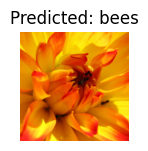

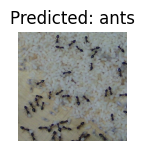

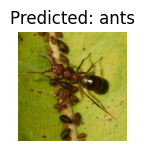

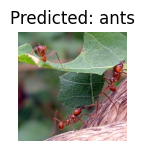

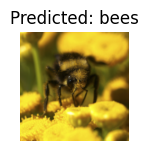

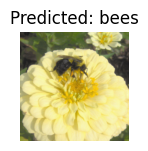

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                imshow(inputs[j].cpu())

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

visualize_model(model_ft)


# ✅ Conclusiones de la sesión

1. **Transfer Learning es una técnica poderosa** que permite reutilizar modelos entrenados previamente en tareas nuevas con pocos datos, lo que ahorra tiempo y mejora la precisión.

2. **ResNet-18 es ideal para comenzar**, ya que es liviano, preciso y está disponible preentrenado en PyTorch.

3. **El preprocesamiento y las transformaciones son claves** para lograr buenos resultados, incluso con un dataset pequeño.

4. **El fine-tuning permite ajustar completamente el modelo**, mientras que el feature extraction congela las capas y entrena solo la capa final.

5. **La visualización de resultados ayuda a entender errores del modelo** y afinar futuras mejoras.

6. **PyTorch facilita el flujo de trabajo**, desde la carga del modelo hasta la visualización final, siendo una herramienta robusta para aprendizaje profundo aplicado.
